In [1]:
import sys
print(sys.executable)


/Users/aliiii/Desktop/projects/Adversarial-attacks-/.venv/bin/python


In [2]:
import torch
torch.__version__


'2.8.0'

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



device(type='cpu')

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True
)

len(test_dataset)


10000

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = SimpleCNN().to(device)


In [ ]:
model.eval()


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [8]:
x, y = next(iter(test_loader))
print("Pred:", model(x.to(device)).argmax(1).item(), "True:", y.item())

Pred: 3 True: 3


In [9]:
def deepfool(model, image, num_classes=10, overshoot=0.02, max_iter=50):
    """
    image: [1, 1, 28, 28]
    return: x_adv, perturbation (tensor)
    """

    model.eval()
    x = image.clone().detach().to(device)
    x.requires_grad_(True)

    # Initial prediction
    with torch.no_grad():
        logits = model(x)
    label = logits.argmax().item()

    pert_total = torch.zeros_like(x).to(device)

    for _ in range(max_iter):

        # Forward
        logits = model(x)
        preds = logits.argmax().item()
        
        # Stop if model is fooled
        if preds != label:
            break

        # Compute gradient of true class
        logits[0, label].backward(retain_graph=True)
        grad_orig = x.grad.data.clone()

        # Compute perturbations for all other classes
        min_pert = float("inf")
        w_best = None

        for k in range(num_classes):
            if k == label:
                continue

            x.grad.zero_()
            logits[0, k].backward(retain_graph=True)
            grad_k = x.grad.data.clone()

            w_k = grad_k - grad_orig
            f_k = (logits[0, k] - logits[0, label]).item()

            pert_k = abs(f_k) / (w_k.flatten().norm() + 1e-8)

            if pert_k < min_pert:
                min_pert = pert_k
                w_best = w_k

        # Compute minimal perturbation
        r_i = (min_pert + 1e-4) * w_best / (w_best.flatten().norm() + 1e-8)
        pert_total += r_i

        # Update image
        x = (image + (1 + overshoot) * pert_total).detach()
        x.requires_grad_(True)

    x_adv = torch.clamp(x, 0, 1)
    return x_adv.detach(), pert_total.detach()


In [10]:
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)

x_adv, r = deepfool(model, x)

print("Original label:", y.item())
print("Adversarial label:", model(x_adv).argmax().item())
print("L2 norm of perturbation:", torch.norm(r).item())


Original label: 7
Adversarial label: 3
L2 norm of perturbation: 1.825582504272461


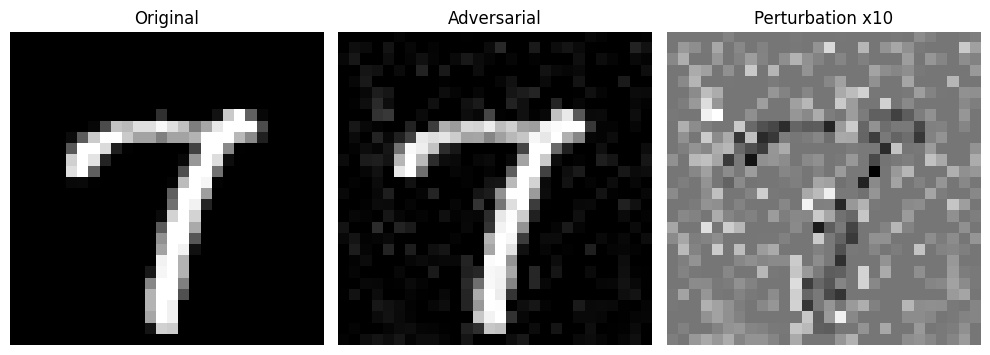

In [11]:
def show(img, title=""):
    img = img.detach().cpu().squeeze().numpy()
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
show(x, "Original")

plt.subplot(1,3,2)
show(x_adv, "Adversarial")

plt.subplot(1,3,3)
show((x_adv - x)*10, "Perturbation x10")

plt.tight_layout()
plt.show()


In [12]:
correct = 0
total = 0

for i, (x, y) in enumerate(test_loader):
    if i >= 500:
        break

    x = x.to(device)
    y = y.to(device)

    x_adv, _ = deepfool(model, x)
    pred = model(x_adv).argmax()

    correct += (pred == y).item()
    total += 1

print("DeepFool Adversarial Accuracy (500 samples) :", correct / total)


DeepFool Adversarial Accuracy (500 samples) : 0.092


In [13]:
L2_list = []

for i, (x, _) in enumerate(test_loader):
    if i >= 200:
        break

    x = x.to(device)
    _, r = deepfool(model, x)
    L2_list.append(torch.norm(r).item())

print("Mean L2:", np.mean(L2_list))
print("Std L2:", np.std(L2_list))


Mean L2: 1.5956027460098268
Std L2: 0.3292146349735178
